# Test avec les trucs linéaires là

## Récupération des données

In [1]:
import os

In [2]:
os.getcwd()

'/home/franzele/Desktop/univ_lille/sd/facial_emotion_classification_sd/scripts'

In [3]:
os.chdir("..")

In [4]:
PATH_TO_DATA = "CK+_lands/CK+_centered"
PATH_TO_LABEL = "CK+_lands/CK+/emotion.csv"

In [5]:
import pandas as pd

In [6]:
def load_last_faces(data, labels, only_labelled=True):
    def fuse_df(base_df, visage_dir, tmp_id, data, target=-1):
        coords = {str(i):x for i, x in enumerate(data.to_numpy())}
        new_line = {
            "subject": visage_dir,
            "file": tmp_id,
        }
        new_line = new_line | coords
        new_line = pd.DataFrame(new_line, index=[0])

        # new_line["coords"] = new_line.iloc[:, 2:].to_numpy().tolist()

        # new_line = new_line.drop([str(i) for i in range(136)], axis=1)
        return pd.concat([base_df, new_line])

    last_faces = pd.DataFrame()
    labels = pd.read_csv(labels, delimiter=";")

    for visage_dir in os.listdir(data):
        visage_data = pd.read_csv(os.path.join(data, visage_dir, "omlands.csv"), delimiter=";", header=None)
        tmp_id = visage_data.iloc[0, 0]
        for row_id in visage_data.index:
            if visage_data.iloc[row_id, 0] != tmp_id:
                last_faces = fuse_df(last_faces, visage_dir, tmp_id, visage_data.iloc[row_id-1, 1:])
                tmp_id = visage_data.iloc[row_id, 0]
        last_faces = fuse_df(last_faces, visage_dir, tmp_id, visage_data.iloc[row_id-1, 1:])


    last_faces = pd.merge(last_faces, labels, on=["subject", "file"], how="inner" if only_labelled else "outer")
    
    return last_faces

In [7]:
data = load_last_faces(PATH_TO_DATA, PATH_TO_LABEL)

## Séparation des données

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


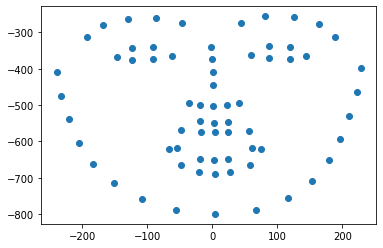

In [9]:
plt.scatter(data.loc[0, "0":"135":2], -data.loc[0, "1":"135":2])

In [10]:
scaler = StandardScaler().fit(data.loc[:, "0":"135"])
new_data = scaler.transform(data.loc[:, "0":"135"])

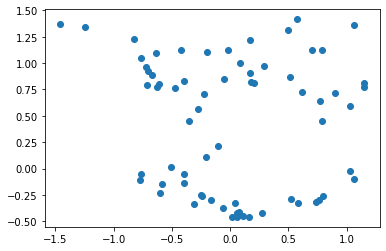

In [11]:
plt.scatter(new_data[0, 0::2], -new_data[0, 1::2])

In [12]:
x_scaler = StandardScaler().fit(data.loc[:, "0":"135":2])
y_scaler = StandardScaler().fit(data.loc[:, "1":"135":2])
new_data = data.copy()
new_data.loc[:, "0":"135":2] = x_scaler.transform(data.loc[:, "0":"135":2])
new_data.loc[:, "1":"135":2] = y_scaler.transform(data.loc[:, "1":"135":2])

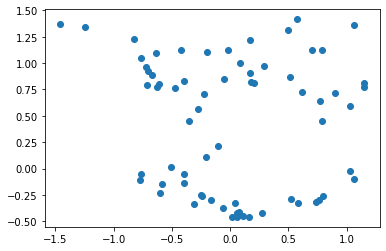

In [13]:
plt.scatter(new_data.loc[0, "0":"135":2], -new_data.loc[0, "1":"135":2])

On va continuer à utiliser les points non standardisé, pour savoir quand on fait une erreure

In [14]:
points = np.arange(68)

In [15]:
points[0:9]     = 0
points[9:17]    = 1
points[17:22]   = 2
points[22:27]   = 3
points[27:36]   = 4
points[36:42]   = 5
points[42:48]   = 6
points[48:56]   = 7
points[61:66]   = 7
points[55:61]   = 8
points[65:69]   = 8

points

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 8,
       8, 8])

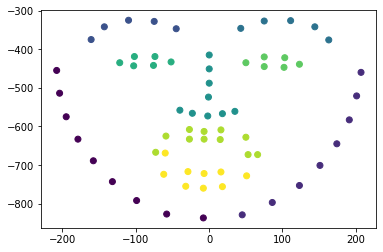

In [16]:
plt.scatter(data.loc[4, "0":"135":2], -data.loc[4, "1":"135":2], c=points,)

## Test avec logistic regression sur les visages entiers

In [17]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [18]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
X_train, X_test, y_train, y_test = train_test_split(data.loc[:, "0":"135"], data.loc[:, "emotion"])

In [20]:
cross_val_score(LogisticRegression(), data.loc[:, "0":"135"], data.loc[:, "emotion"]).mean()

0.8485524256651017

In [ ]:
params = {
    "penalty": ["l1", "l2", "elasticnet", None],
    "tol": [10**x for x in range(-4, -1)],
    "max_iter": [50, 100, 500, 1000, 5000],
    "multi_class": ["auto", "ovr", "multinomial"]
}

In [ ]:
grid_search = GridSearchCV(LogisticRegression(), param_grid=params, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_estimator_

In [21]:
best_lr = LogisticRegression(multi_class="ovr", max_iter=5000)

cross_val_score(best_lr, data.loc[:, "0":"135"], data.loc[:, "emotion"]).mean()

KeyboardInterrupt: 

In [ ]:
cross_val_score(best_lr, new_data.loc[:, "0":"135"], new_data.loc[:, "emotion"]).mean()

## Logstic Regression avec séparation des points

In [22]:
def colonne_zone(zone):
    match zone:
        case 0:         # joue gauche
            return [str(2*x+y) for x in range(9) for y in range(2)]
        case 1:         # joue droite
            return [str(2*x+y) for x in range(9, 17) for y in range(2)]
        case 2:         # sourcil gauche
            return [str(2*x+y) for x in range(17, 22) for y in range(2)]
        case 3:         # sourcil droite
            return [str(2*x+y) for x in range(22, 27) for y in range(2)]
        case 4:         # nez
            return [str(2*x+y) for x in range(27, 36) for y in range(2)]
        case 5:         # oeil gauche
            return [str(2*x+y) for x in range(36, 42) for y in range(2)]
        case 6:         # oeil droite
            return [str(2*x+y) for x in range(42, 48) for y in range(2)]
        case 7:         # lèvre supéreure
            return [str(2*x+y) for x in range(48, 56) for y in range(2)] + \
                    [str(2*x+y) for x in range(61, 65) for y in range(2)]
        case 8:         # lèvre inférieure
            return [str(2*x+y) for x in range(55, 61) for y in range(2)] + \
                    [str(2*x+y) for x in range(64, 68) for y in range(2)]



In [23]:
colonne_zone(8)

['110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135']

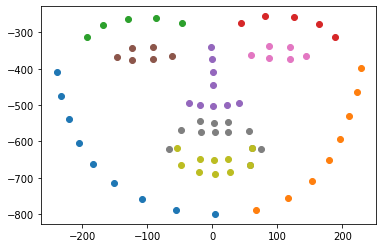

In [24]:
for i in range(9):
    plt.scatter(data.loc[0, colonne_zone(i)[::2]], -data.loc[0, colonne_zone(i)[1::2]])

In [25]:
class LR_zone():
    def __init__(self) -> None:
        self.zones = {i:LogisticRegression() for i in range(9)}
        self.weights = [
            0,          # joue gauche
            0,          # joue droite
            1,          # sourcil gauche
            1,          # sourcil droite
            0,          # nez
            1,          # oeil gauche
            1,          # oeil droite
            4,          # lèvre supérieure
            4,          # lèvre inférieure
        ]

    def fit(self, X, y) -> None:
        for key in self.zones:
            self.zones[key] = self.zones[key].fit(X.loc[:, colonne_zone(key)], y)
    
    def predict(self, X):
        X = X.to_frame().transpose()
        X.columns = [str(i) for i in range(136)]
        result = []
        for key in self.zones:
            zone_result = self.zones[key].predict(X.loc[:, colonne_zone(key)])
            for _ in range(self.weights[key]):
                result.append(zone_result)
        return max(result, key=result.count)[0]

In [26]:
face_zone = LR_zone()

In [27]:
face_zone.fit(X_train, y_train)

In [28]:
face_zone.predict(X_test.iloc[1, :])

3

In [29]:
true_counter = 0
for i in X_test.index:
    if face_zone.predict(X_test.loc[i, :]) == y_test[i]:
        true_counter += 1
true_counter / len(X_test)

0.8

## Avec Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
bag = BaggingClassifier(estimator=LogisticRegression(multi_class="ovr", max_iter=5000))

In [ ]:
cross_val_score(bag, data.loc[:, "0":"135"], data.loc[:, "emotion"]).mean()

In [ ]:
cross_val_score(BaggingClassifier(estimator=LogisticRegression(multi_class="ovr"), n_estimators=50), 
                data.loc[:, "0":"135"], data.loc[:, "emotion"]).mean()

In [ ]:
%%script false --no-raise-error
params = {
    "n_estimators": [10, 50, 100],
    "estimator__penalty": ["l1", "l2", "elasticnet", None],
    "estimator__tol": [10**x for x in range(-4, -1)],
    "estimator__max_iter": [50, 100, 500, 1000, 5000],
    "estimator__multi_class": ["auto", "ovr", "multinomial"]
}

grid_search = GridSearchCV(BaggingClassifier(estimator=LogisticRegression()), param_grid=params, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

## Test avec beaucoup plus de données 

In [30]:
def create_data(data:pd.DataFrame, final_number:int, random_range=2):
    new_faces_nb = final_number // len(data["emotion"].value_counts()) + 1
    new_data = []
    new_faces_count = {}
    while len(data)+len(new_data) < final_number:
        for emotion in data["emotion"].unique():
            if emotion not in new_faces_count:
                new_faces_count[emotion] = 0

            if len(data.where(data["emotion"] == emotion).dropna()) + new_faces_count[emotion] < new_faces_nb:
                new_faces_count[emotion] += 1
                new_line = data.where(data["emotion"] == emotion).dropna().sample()
                for i in range(136):
                    new_line[str(i)] = new_line[str(i)] + np.random.uniform(-random_range, random_range)
                new_data.append(new_line.to_numpy().tolist()[0])
    return pd.concat([data, pd.DataFrame(new_data, columns=data.columns)], ignore_index=True)

In [ ]:
more_data = create_data(data, 500)

In [ ]:
more_data["emotion"].value_counts()

In [ ]:
more_data.loc[:, "0":"135"]

In [ ]:
cross_val_score(bag, more_data.loc[:, "0":"135"], more_data.loc[:, "emotion"], cv=5, n_jobs=-1).mean()

In [ ]:
best_lr = LogisticRegression(multi_class="ovr", max_iter=5000)

cross_val_score(best_lr, more_data.loc[:, "0":"135"], more_data.loc[:, "emotion"], n_jobs=-1).mean()

In [31]:
even_more_data = create_data(data, 5000, 5)

In [32]:
len(even_more_data)

5000

In [ ]:
cross_val_score(best_lr, even_more_data.loc[:, "0":"135"], even_more_data.loc[:, "emotion"], n_jobs=-1).mean()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(even_more_data.loc[:, "0":"135"], even_more_data.loc[:, "emotion"], test_size=0.2)

In [34]:
best_lr.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr')

In [35]:
best_lr.score(X_test, y_test)

0.941